In [1]:
import os
import numpy as np
import h5py
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from pytorch_lightning import LightningModule
from sklearn.model_selection import train_test_split

In [2]:
# Path setup
model_path = "best_model_v13_Lum---epoch=4986-val_loss=0.00769697.ckpt"  
garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'

In [3]:
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.LeakyReLU(),
            nn.Linear(64, output_dim)
        )
        
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

In [4]:
def load_data():
    # 7 Inputs
    ages = []
    massini = []
    fehini = []
    alphamlt = []
    yini = []
    eta = []
    alphafe = []

    # 5 Outputs
    teff = []
    luminosity = []
    dnufit = []
    FeH = []
    numax = []

    # Open the hdf5 file (read-only mode)
    with h5py.File(garstec_data, 'r') as hdf:
        grid = hdf['grid']
        tracks = grid['tracks']

        # Get a list of track names and shuffle for random sampling
        track_names = list(tracks.keys())
        random.seed(1)
        random.shuffle(track_names)

        # Choose a subset of tracks to process (or not)
        selected_tracks = track_names[:]

        for track_name in selected_tracks:  # Iterate over the selected track names
            track = tracks[track_name]
            # Inputs
            ages.append(track['age'][:])
            massini.append(track['massini'][:])
            fehini.append(track['FeHini'][:])
            alphamlt.append(track['alphaMLT'][:])
            yini.append(track['yini'][:])
            eta.append(track['eta'][:])
            alphafe.append(track['alphaFe'][:])

            # Outputs
            teff.append(track['Teff'][:])
            luminosity.append(track['LPhot'][:])
            dnufit.append(track['dnufit'][:])
            FeH.append(track['FeH'][:])
            numax.append(track['numax'][:])
        
        # Track which points belong to which tracks
        track_indices = []
        for i, track_name in enumerate(selected_tracks):
            track = tracks[track_name]
            # Add the track index for each point in this track
            track_indices.extend([i] * len(track['Teff'][:]))
    
    track_indices = np.array(track_indices)

    # Convert lists to numpy arrays and concatenate directly (no log transformation)
    input_arrays = [
        np.concatenate(ages).reshape(-1, 1),
        np.concatenate(massini).reshape(-1, 1),
        np.concatenate(fehini).reshape(-1, 1),
        np.concatenate(alphamlt).reshape(-1, 1),
        np.concatenate(yini).reshape(-1, 1),
        np.concatenate(eta).reshape(-1, 1),
        np.concatenate(alphafe).reshape(-1, 1)
    ]

    # Concatenate all inputs
    inputs = np.hstack(input_arrays)

    # Concatenate all outputs
    output_arrays = [
        np.concatenate(teff).reshape(-1, 1),
        np.concatenate(luminosity).reshape(-1, 1),
        np.concatenate(dnufit).reshape(-1, 1),
        np.concatenate(numax).reshape(-1, 1),
        np.concatenate(FeH).reshape(-1, 1)
    ]

    # Combine outputs
    outputs = np.hstack(output_arrays)

    
    # Create a list of output parameter names for plotting
    output_names = ['T_eff', 'Luminosity', 'dnu', 'numax', 'FeH']
    
    return inputs, outputs, output_names, track_indices




In [5]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
# Load data
inputs, outputs, output_names, track_indices = load_data()
    
# Select just one output feature (index 0 for Teff)
output_index = 1  # Change this to select different outputs (0=Teff, 1=luminosity, 2=dnu, 3=numax, 4=FeH)
selected_output = outputs[:, output_index:output_index+1]  # Keep 2D shape with one column
selected_output_name = output_names[output_index]

# Split data with selected output
X_train, X_test, y_train, y_test = train_test_split(inputs, selected_output, test_size=0.2, random_state=1)

# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Update output_dim to match the selected output
input_dim = X_train.shape[1]
output_dim = 1  # Single output feature

# Load model with map_location to handle device differences
model = GarstecNet.load_from_checkpoint(
    model_path, 
    input_dim=input_dim, 
    output_dim=output_dim,
    map_location=device
)
model.eval()  # Set to evaluation mode
model.to(device)  # Ensure model is on the correct device
    
# Make predictions on test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()  # Move predictions back to CPU before converting to numpy
    
# Inverse transform predictions and actual values to get original scale
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)
    
# Calculate residuals (no log transformation needed anymore)
normal_residuals = y_pred_original - y_test_original

Using device: cuda


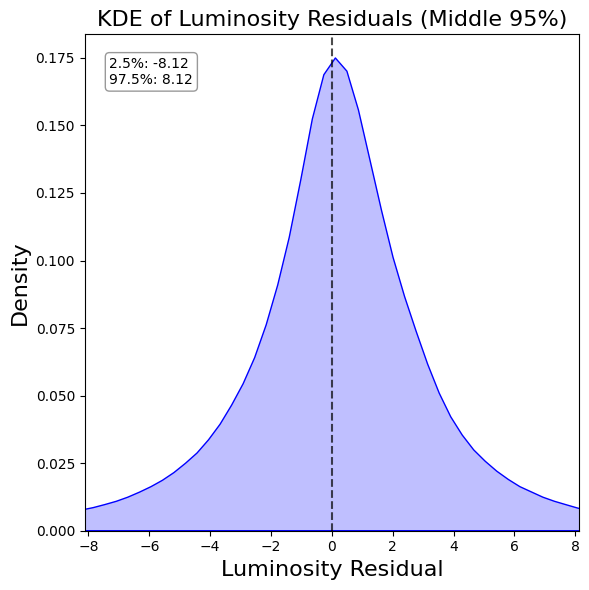

In [6]:
def individual_kde_plot(residuals, output_name):
    # Extract residuals which are now a single column
    residual = residuals.flatten()  # Flatten in case it's still a 2D array
    
    # Calculate the 2.5th and 97.5th percentiles (middle 95%)
    lower_bound = np.percentile(residual, 2.5)
    upper_bound = np.percentile(residual, 97.5)
    
    plt.figure(figsize=(6, 6))
    
    # Create KDE plot
    sns.kdeplot(x=residual, fill=True, color='blue')
    
    # Add reference line at zero
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Set x-axis limits to show only middle 95%
    plt.xlim(lower_bound, upper_bound)
    
    # Add title and labels
    plt.title(f'KDE of {output_name} Residuals (Middle 95%)', fontsize=16)
    plt.xlabel(f'{output_name} Residual', fontsize=16)
    plt.ylabel('Density', fontsize=16)

    # Display percentile values in a text box
    plt.annotate(f'2.5%: {lower_bound:.2f}\n97.5%: {upper_bound:.2f}', 
                xy=(0.05, 0.9), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

selected_output_name = output_names[output_index]
individual_kde_plot(normal_residuals, selected_output_name)